<a href="https://colab.research.google.com/github/rajlm10/Shoppster/blob/main/Plots_and_Figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt

In [2]:
!pip install -Uq sentence_transformers
!pip install transformers

     |████████████████████████████████| 85 kB 4.5 MB/s 
     |████████████████████████████████| 5.5 MB 53.6 MB/s 
     |████████████████████████████████| 1.3 MB 62.2 MB/s 
     |████████████████████████████████| 182 kB 65.0 MB/s 
     |████████████████████████████████| 7.6 MB 35.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import os
import torch
from torch import nn
from transformers import AutoFeatureExtractor, AutoModel
from torchvision import transforms
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer, models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, SequentialSampler
import math
from PIL import Image
import torch.nn.functional as F
tqdm.pandas()

#Training Curves

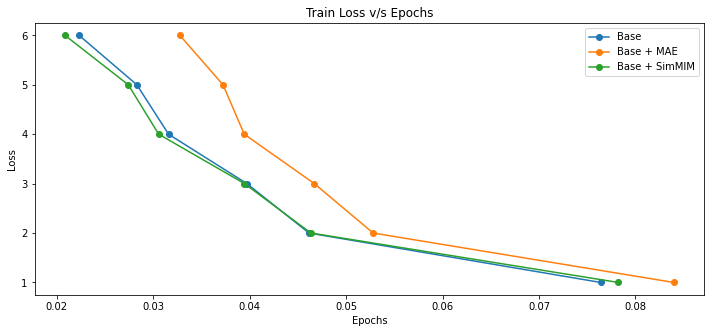

In [ ]:
vit_base = [0.0763904160442166,0.04615559127917129,0.03971667950993117,0.031598217330808365,0.028308748456481805,0.022323456645383623]

vit_mae = [0.08396809749757778,0.052805211993011116,0.04671032760704417,0.03944315731832495,0.037241187225421184,0.032768755379474344]

vit_mim = [0.07821238135066441,0.046351052699469174,0.03946993156152408,0.03057539829309553,0.02742294079993817,0.020863946564616778]

plt.figure(figsize=(12,5));

ax = plt.plot(vit_base,[i+1 for i in range(6)],marker="o",label=f'Base');
ax = plt.plot(vit_mae,[i+1 for i in range(6)],marker="o",label=f'Base + MAE');
ax = plt.plot(vit_mim,[i+1 for i in range(6)],marker="o",label=f'Base + SimMIM');


plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train Loss v/s Epochs")
plt.legend()
plt.show()

#Validation Curves

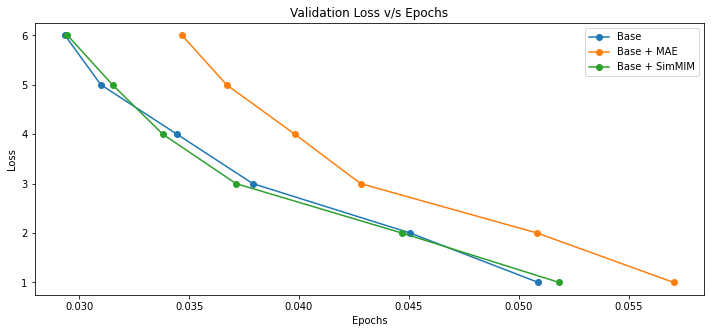

In [ ]:
vit_base = [0.05089748904494376,0.04506280427349025,0.037899874664586164,0.03444831834399495,0.030985873224663323,0.029353605470909126]

vit_mae = [0.05705761231867404,0.050843670739439024,0.04280734286996825,0.03981437648100586,0.036707375567920246,0.03468170106924813]

vit_mim = [0.05184409375591525,0.044686719903658176,0.03713609303893714,0.033803972431683336,0.03151630351705284,0.029466490004340123]


plt.figure(figsize=(12,5));

ax = plt.plot(vit_base,[i+1 for i in range(6)],marker="o",label=f'Base');
ax = plt.plot(vit_mae,[i+1 for i in range(6)],marker="o",label=f'Base + MAE');
ax = plt.plot(vit_mim,[i+1 for i in range(6)],marker="o",label=f'Base + SimMIM');


plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss v/s Epochs")
plt.legend()
plt.show()

#Recall Curves

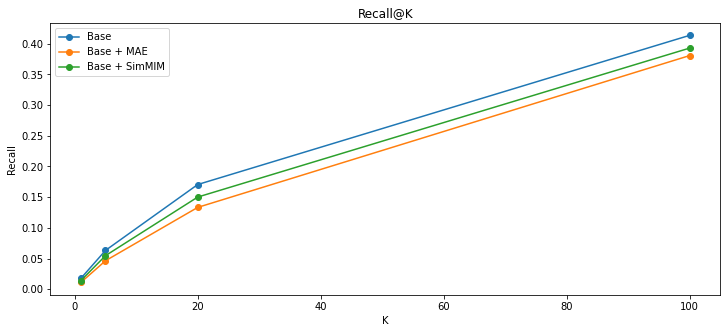

In [ ]:
x = [1,5,20,100]

vit_base = [0.017808580858085815,0.06331023102310228,0.17059075907590732,0.41350495049504976]

vit_mae = [0.011155115511551149,0.046481848184818486,0.13336963696369628,0.38054455445544555]

vit_mim = [0.014184818481848192,0.05475247524752475,0.150188118811881,0.3927392739273924]

plt.figure(figsize=(12,5));

ax = plt.plot(x,vit_base,marker="o",label=f'Base');
ax = plt.plot(x,vit_mae,marker="o",label=f'Base + MAE');
ax = plt.plot(x,vit_mim,marker="o",label=f'Base + SimMIM');


plt.xlabel("K")
plt.ylabel("Recall")
plt.title("Recall@K")
plt.legend()
plt.show()

#Search

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self, model_name="google/vit-base-patch16-224-in21k", pretrained=True, trainable=True, device=None):
        super().__init__()
        self.device = device
        self.model = AutoModel.from_pretrained(model_name)

        self.model.to(self.device)
        
        if trainable:
          for p in self.model.parameters():
              p.requires_grad = trainable

    def forward(self, image_inputs):
        image_inputs = {k:v.to(self.device) for k,v in image_inputs.items()}
        image_outputs = self.model(**image_inputs)
        image_embedding = image_outputs.pooler_output 
        return image_embedding

class TextEncoder(nn.Module):

    def __init__(self, model_name="sentence-transformers/all-mpnet-base-v2", trainable=True, device=None):
        super().__init__()
        self.device=device
        word_embedding_model = models.Transformer(model_name)
        pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'mean')
        self.model = SentenceTransformer(modules=[word_embedding_model, pooling_model], device=device)
        self.model.to(self.device)

        if trainable:    
          for p in self.model.parameters():
              p.requires_grad = trainable

    def forward(self, text):
        attr_embedding = self.model.encode(text, convert_to_tensor=True, device=self.device)
        return attr_embedding

class FashionDataset(Dataset):

    def __init__(self, root_dir, df):
        self.df = df
        self.root_dir = root_dir
        self.processor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")    
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        image_file = self.root_dir + "/" + self.df["image_id"][idx]
        positive = self.df['positive'][idx] 
        negative = self.df['negative'][idx] 
        image = Image.open(image_file).convert("RGB")

        encoding={}
        encoding["image_name"] = self.df["image_id"][idx]

        pixel_vals = self.processor(image, return_tensors="pt").pixel_values #The preprocessor will take care of resizing.
        encoding["anchor"] = {"pixel_values" : pixel_vals.squeeze(0)}

        encoding["pos"] = positive
        encoding["neg"] = negative
        

        return encoding

class Network(nn.Module):

    def __init__(self, hyperparms=None):

        super(Network, self).__init__()  
        self.vision_projection = nn.Linear(hyperparms["vision_dim"], hyperparms["proj_dim"])
        self.text_projection = nn.Linear(hyperparms["text_dim"], hyperparms["proj_dim"])     
        self.dropout = nn.Dropout(0.1)

        device = hyperparms["device"]
        model_name = hyperparms["model_name"]
        self.image_encoder = ImageEncoder(model_name, device=device)


        self.text_encoder = TextEncoder(device=device)
        EUCLIDEAN = lambda x, y: F.pairwise_distance(x, y, p=2)
        self.criterion = nn.TripletMarginWithDistanceLoss(margin=0.2, distance_function=EUCLIDEAN, reduction="mean")
        self.relu_f = nn.ReLU()

    def forward(self, batch):

        # Getting Image and Text Features
        image_emb = self.image_encoder(batch["anchor"])
        image_emb = torch.nn.functional.normalize(image_emb, p=2, dim=1)
        
        # Getting Image and Text Embeddings (with same dimension)
        image_emb = self.relu_f(self.vision_projection(image_emb))
        image_emb = self.dropout(image_emb)

        pos_emb = self.text_encoder(batch["pos"])
        pos_emb = torch.nn.functional.normalize(pos_emb, p=2, dim=1)
        pos_emb = self.relu_f(self.text_projection(pos_emb))
        pos_emb = self.dropout(pos_emb)

        neg_emb = self.text_encoder(batch["neg"])
        neg_emb = torch.nn.functional.normalize(neg_emb, p=2, dim=1)
        neg_emb = self.relu_f(self.text_projection(neg_emb))
        neg_emb = self.dropout(neg_emb)

        # Calculating the Loss
        loss = self.criterion(image_emb, pos_emb, neg_emb)       #Triplet Loss calculation
        return loss


In [4]:
import pandas as pd

In [5]:
!mkdir ~/.kaggle/
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip -qq /content/fashion-product-images-small.zip 

100% 564M/565M [00:28<00:00, 23.0MB/s]
100% 565M/565M [00:28<00:00, 20.9MB/s]


In [6]:
data = pd.read_csv('triplet_data.csv')

In [7]:
search_dataframe = data[['anchor','positive']].drop_duplicates().reset_index(drop=True)
search_dataframe=search_dataframe.rename(columns={"anchor":"image_id"})
search_dataframe['image_id']=search_dataframe['image_id'].apply(lambda x: str(x)+'.jpg')
values = ['10000.jpg','10000.jpg','39410.jpg','39425.jpg','39403.jpg','39401.jpg']
search_dataframe = search_dataframe[search_dataframe.image_id.isin(values) == False].reset_index(drop=True)
search_dataframe['negative'] = [""]*len(search_dataframe)
search_dataframe

,image_id,positive,negative
0,15970.jpg,Men Casual Navy Blue Shirt,
1,39386.jpg,Men Casual Party Blue Jeans,
2,59263.jpg,Women Casual Silver Watch,
3,53759.jpg,Men Casual Grey T-shirt,
4,1855.jpg,Men Casual Chain Reaction T-shirt,
...,...,...,...
30291,17036.jpg,Men Casual Caddy Casual Shoe,
30292,6461.jpg,Men Casual Soccer Track Flip Flop,
30293,18842.jpg,Men Casual Graphic Stellar Blue Tshirt,
30294,46694.jpg,Women Casual Blue Lady Perfume,


In [8]:
search_dataframe.to_csv('search.csv',index=None)

In [9]:
!cp /content/search.csv /content/drive/MyDrive/MLD

In [ ]:
#check if all file exist in images
for id in set(search_dataframe['image_id']):
  if os.path.exists('/content/images/'+id) == False:
    print(id)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# To use Transformer for Vision 
model = Network(hyperparms={"device": device, "model_name": "google/vit-base-patch16-224-in21k", "vision_dim": 768, "text_dim": 768, "proj_dim": 512})
model.load_state_dict(torch.load(f'/content/drive/MyDrive/MLD/network_epoch_6.model'))
model.to(device)


In [ ]:
!nvidia-smi

Sat Nov 26 07:45:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W /  70W |   2460MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from torch.utils.data import DataLoader, SequentialSampler

search_dataset = FashionDataset(root_dir='./images',df=search_dataframe)


test_batch_size = 512
dataloader_search = DataLoader(search_dataset, 
                                   sampler=SequentialSampler(search_dataset), 
                                   batch_size=test_batch_size)

In [ ]:
def get_image_embeddings():
    model.eval()
    test_image_embeddings = []
    image_names = []
    with torch.no_grad():
        for batch in tqdm(dataloader_search):
            image_features = model.image_encoder(batch["anchor"])             
            image_names.extend(batch["image_name"])
            image_embeddings = model.vision_projection(image_features)
            test_image_embeddings.append(image_embeddings)
    return image_names, torch.cat(test_image_embeddings)

image_names, image_embeddings = get_image_embeddings()


from sentence_transformers import SentenceTransformer, util
from IPython.display import Image as IPImage
import cv2
import matplotlib.pyplot as plt


img_folder = './images'

def search(query, image_embeddings, img_names, k=3):
    query_emb = model.text_encoder(query)
    query_emb = model.text_projection(query_emb)
    hits = util.semantic_search(query_emb, image_embeddings, top_k=k)[0]
    print(hits)
    print("query:", query)
    
    _, axes = plt.subplots(int(k // 3), 3, figsize=(15, 3))
    for hit, ax in zip(hits, axes.flatten()):
        img_name= img_names[hit['corpus_id']]
        image = cv2.imread(os.path.join(img_folder, img_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.set_xlabel("score: " + str(round(hit["score"],3)) + ", Name:" + img_name)
        ax.imshow(image)
    
    plt.show()

from sentence_transformers import SentenceTransformer, util
from IPython.display import Image as IPImage
import cv2
import matplotlib.pyplot as plt

img_folder = "/content/images"

  0%|          | 0/60 [00:00<?, ?it/s]

In [ ]:
def mm_search(image_query, operand, text_query, image_embeddings, img_names, k=3):

    index = image_names.index(image_query)
    i_query_emb = image_embeddings[index]
    i_query_emb = torch.nn.functional.normalize(i_query_emb, p=2, dim=0)

    t_query_emb = model.text_encoder(text_query)
    t_query_emb = model.text_projection(t_query_emb)
    t_query_emb = torch.nn.functional.normalize(t_query_emb, p=2, dim=0)

    if operand == "+":
       query_emb = i_query_emb + t_query_emb
    else:   
       query_emb = i_query_emb - t_query_emb
       
    hits = util.semantic_search(query_emb, image_embeddings, top_k=k)[0]

    print("query:")
    display(IPImage(os.path.join(img_folder, image_query)))
    print(operand, end=" ")
    print(text_query,end=" ")
    
    _, axes = plt.subplots(int(k // 3), 3, figsize=(15, 3))
    for hit, ax in zip(hits, axes.flatten()):
        img_name= img_names[hit['corpus_id']]
        image = cv2.imread(os.path.join(img_folder, img_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.set_xlabel("score: " + str(round(hit["score"],3)) + ", Name:" + img_name)
        ax.imshow(image)
    
    plt.show()

#Text Search

##Good Performance

The model does well on images and descriptions which appear frequently in the dataset. If we see the most popular colours and items (In the first data analysis notebook) we can see the popular items and colours.

[{'corpus_id': 19160, 'score': 0.7420680522918701}, {'corpus_id': 19308, 'score': 0.7406826615333557}, {'corpus_id': 1093, 'score': 0.7391641139984131}]
query: Men black watch


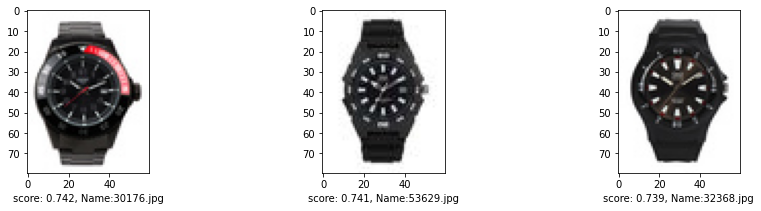

In [ ]:
search("Men black watch", image_embeddings, image_names, 3)  

[{'corpus_id': 30267, 'score': 0.7862122058868408}, {'corpus_id': 19990, 'score': 0.777829647064209}, {'corpus_id': 13914, 'score': 0.7731505036354065}]
query: Men Formal White Shirt


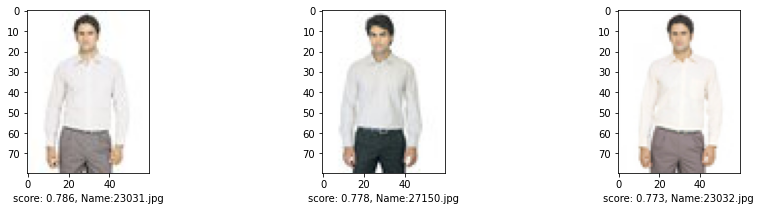

In [ ]:
search("Men Formal White Shirt", image_embeddings, image_names, 3)

[{'corpus_id': 2431, 'score': 0.6958304643630981}, {'corpus_id': 23450, 'score': 0.6953855156898499}, {'corpus_id': 16664, 'score': 0.6881610155105591}]
query: Women Handbag


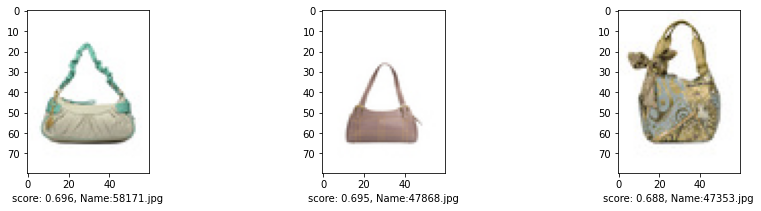

In [ ]:
search("Women Handbag", image_embeddings, image_names, 3)

[{'corpus_id': 91, 'score': 0.6997181177139282}, {'corpus_id': 4326, 'score': 0.6996461153030396}, {'corpus_id': 25879, 'score': 0.6996023058891296}]
query: Women Ethnic Kurta


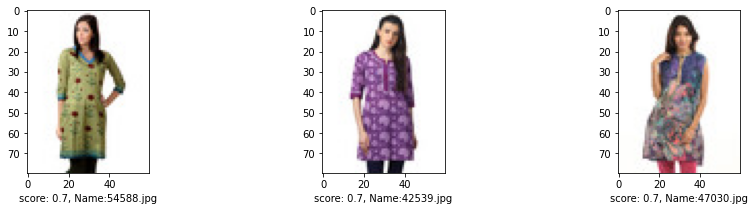

In [ ]:
search("Women Ethnic Kurta", image_embeddings, image_names, 3)

[{'corpus_id': 5974, 'score': 0.8447216153144836}, {'corpus_id': 17164, 'score': 0.8439661264419556}, {'corpus_id': 5650, 'score': 0.8433524966239929}]
query: Women Black Top


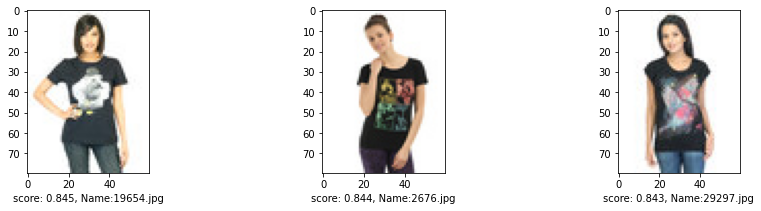

In [ ]:
search("Women Black Top", image_embeddings, image_names, 3)

[{'corpus_id': 23231, 'score': 0.6918220520019531}, {'corpus_id': 23144, 'score': 0.6764465570449829}, {'corpus_id': 19767, 'score': 0.6750282645225525}]
query: Men Brown Belt


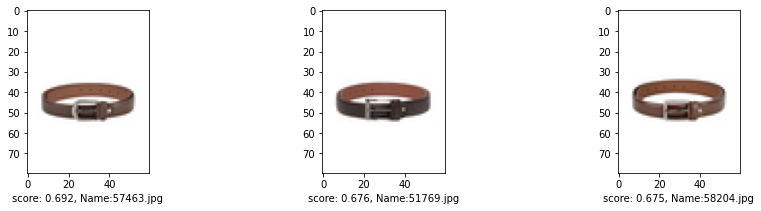

In [ ]:
search("Men Brown Belt", image_embeddings, image_names, 3)

##Poor Performance

The model does not do well on images and descriptions which appear less frequently in the dataset. Moreover, I noticed that the model finds it difficult to identify colours

[{'corpus_id': 22731, 'score': 0.7347291707992554}, {'corpus_id': 12365, 'score': 0.7346171140670776}, {'corpus_id': 18468, 'score': 0.7313404679298401}]
query: Men Casual Yellow Party Shirt


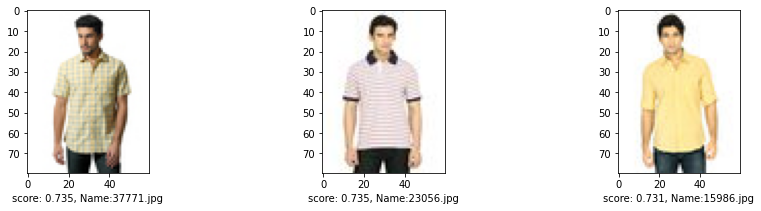

In [ ]:
search("Men Casual Yellow Party Shirt", image_embeddings, image_names, 3)

[{'corpus_id': 2505, 'score': 0.6294882297515869}, {'corpus_id': 8557, 'score': 0.623798668384552}, {'corpus_id': 21995, 'score': 0.6212822794914246}]
query: Men Chronograph Watch


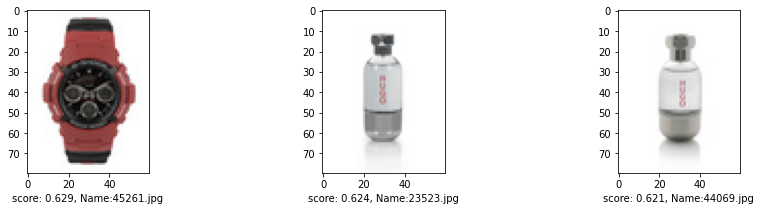

In [ ]:
search("Men Chronograph Watch", image_embeddings, image_names, 3)

[{'corpus_id': 13307, 'score': 0.7882363796234131}, {'corpus_id': 27787, 'score': 0.7882363796234131}, {'corpus_id': 7687, 'score': 0.7750298380851746}]
query: Men Striped Polo T-Shirt


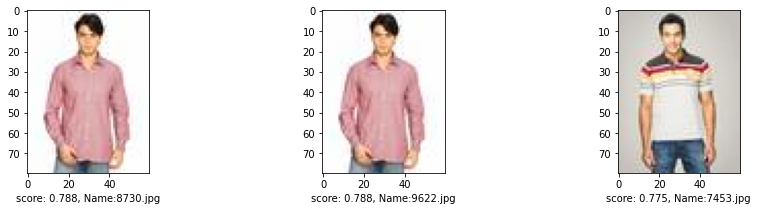

In [ ]:
search("Men Striped Polo T-Shirt", image_embeddings, image_names, 3)

[{'corpus_id': 17607, 'score': 0.6681786775588989}, {'corpus_id': 6440, 'score': 0.6542367339134216}, {'corpus_id': 2410, 'score': 0.6406591534614563}]
query: Women Small Black Handbag


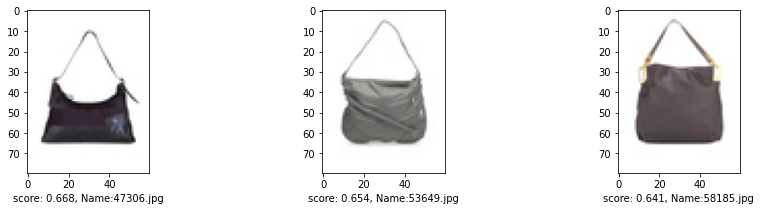

In [ ]:
search("Women Small Black Handbag", image_embeddings, image_names, 3)

[{'corpus_id': 18273, 'score': 0.7389825582504272}, {'corpus_id': 29000, 'score': 0.7241605520248413}, {'corpus_id': 19578, 'score': 0.7237745523452759}]
query: Women Party Dress


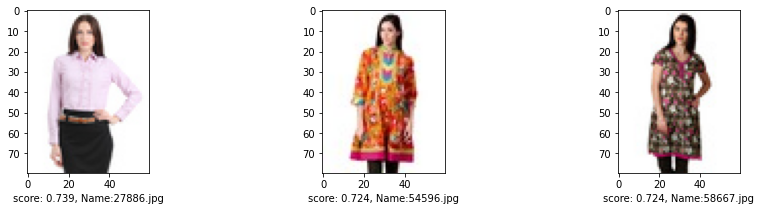

In [ ]:
search("Women Party Dress", image_embeddings, image_names, 3)

#Image + Text Search

query:


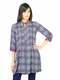

- Check 

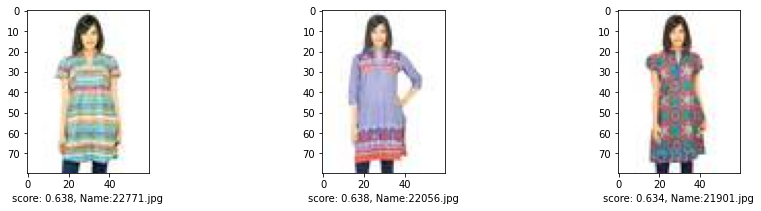

In [ ]:
mm_search("22747.jpg", "-", "Check", image_embeddings, image_names, 3)

query:


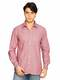

- Red 

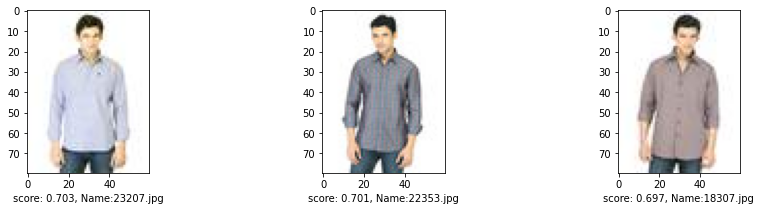

In [ ]:
mm_search("8730.jpg", "-", "Red", image_embeddings, image_names, 3)

query:


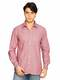

+ Black 

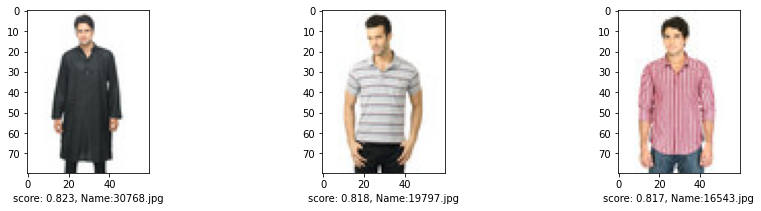

In [ ]:
mm_search("8730.jpg", "+", "Black", image_embeddings, image_names, 3)

query:


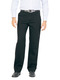

- Formal 

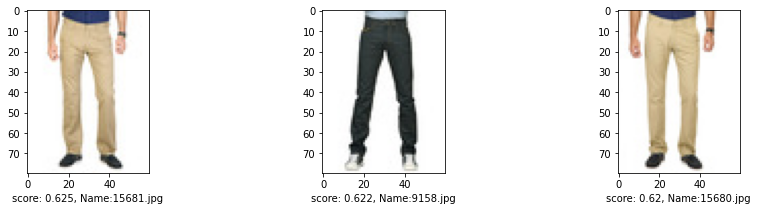

In [ ]:
mm_search("21599.jpg", "-", "Formal", image_embeddings, image_names, 3)

query:


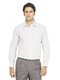

- Formal 

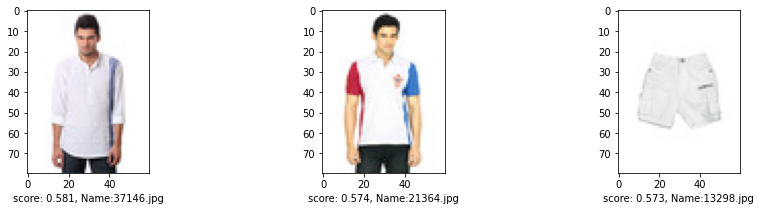

In [ ]:
mm_search("23031.jpg", "-", "Formal", image_embeddings, image_names, 3)

query:


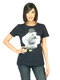

- Black 

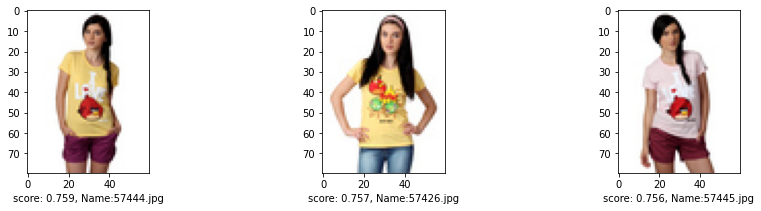

In [ ]:
mm_search("19654.jpg", "-", "Black", image_embeddings, image_names, 3)